In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xarray as xr
import ctdproc as ctd
import matplotlib.pyplot as plt
import warnings
from pathlib import Path

In [3]:
import warnings
warnings.simplefilter("error")

In [4]:
stn = 20

ctd_raw = Path('/Users/hdrake/Documents/data/BLT2/raw/CTD/')
file = f'DY138_{stn:03d}.hex'
hexfile = ctd_raw.joinpath(file)


In [5]:
print(f'Converting hex file for stn {stn}...')
c = ctd.io.CTDx(hexfile)

Converting hex file for stn 20...


In [6]:
c['t1'].data[10000] = 5.
c['c2'].data[20000:20100] = -5.
c['p'].data[15000] = 500.

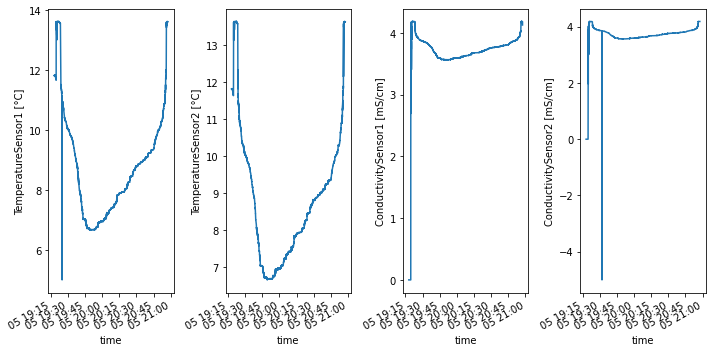

In [7]:
plt.figure(figsize=(10,5))
ctd.proc.plot_profile(c, ['t1', 't2', 'c1', 'c2'])
plt.tight_layout()

(1210.777067159218, -10.0)

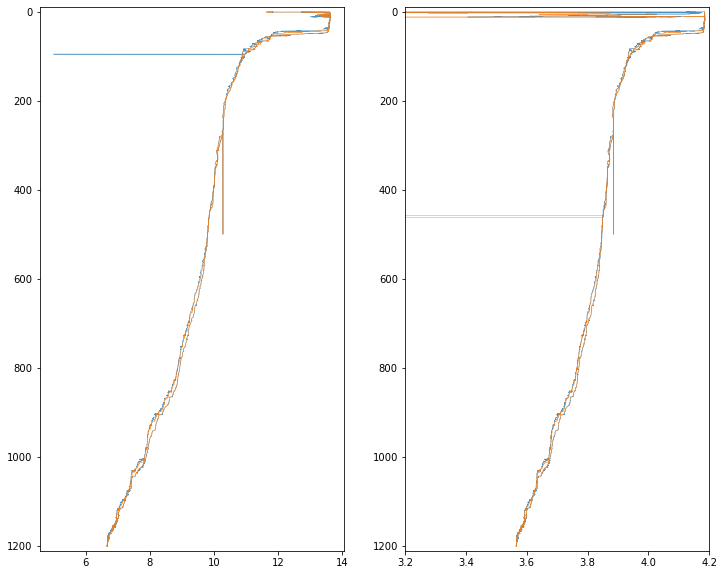

In [8]:
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.plot(c['t1'], c['p'], alpha=0.8, lw=0.5)
plt.plot(c['t2'], c['p'], alpha=0.8, lw=0.5)
plt.ylim(c['p'].max()+10, -10)

plt.subplot(1,2,2)
plt.plot(c['c1'], c['p'], alpha=0.8, lw=0.5)
plt.plot(c['c2'], c['p'], alpha=0.8, lw=0.5)
plt.xlim(3.2, 4.2)
plt.ylim(c['p'].max()+10, -10)

In [9]:
c

<xarray.Dataset>
Dimensions:   (time: 143584)
Coordinates:
  * time      (time) datetime64[ns] 2021-10-05T19:17:55 ... 2021-10-05T20:57:...
Data variables:
    lon       (time) float64 -11.82 -11.82 -11.82 ... -11.82 -11.82 -11.82
    lat       (time) float64 54.17 54.17 54.17 54.17 ... 54.17 54.17 54.17 54.17
    p         (time) float64 1.226 1.226 1.295 1.226 ... 0.1909 0.2694 0.1221
    t1        (time) float64 11.82 11.82 11.82 11.82 ... 13.62 13.62 13.62 13.62
    t2        (time) float64 11.81 11.81 11.81 11.81 ... 13.63 13.63 13.63 13.63
    c1        (time) float64 0.0004142 0.0004207 0.0004142 ... 4.16 4.146 4.128
    c2        (time) float64 0.000207 0.000207 0.000207 ... 4.184 4.184 4.184
    alt       (time) float64 75.0 75.0 75.0 75.0 75.0 ... 75.0 75.0 75.0 75.0
    trans     (time) float64 71.96 71.96 71.96 71.96 ... 96.49 96.52 96.52 96.49
    modcount  (time) int64 226 227 228 229 230 231 ... 188 189 190 191 192 193
Attributes: (12/18)
    verbose:         False
    bounds_p:        [0.0, 6200.0]
    bounds_t:        [-2.0, 40.0]
    bounds_c:        [2.5, 6.0]
    bounds_s:        [20, 38]
    spike_thresh_t:  0.5
    ...              ...
    diff_t:          0.1
    diff_s:          0.001
    diff_p:          2.0
    wthresh:         0.1
    plot_spectra:    None
    plot_path:       None

In [10]:
c1 = ctd.proc.cleanup(c.copy())

In [11]:
def compare(c, c1):
    shiftT = 2.
    shiftS = 0.2

    plt.figure(figsize=(12,5))
    plt.subplot(1,4,1)
    plt.plot(c['t1'], c['p'], alpha=0.8, lw=0.5, label="before")
    plt.plot(c1['t1']+shiftT, c1['p'], alpha=0.8, lw=0.5, label="after")
    plt.ylim(c['p'].max()+10, -10)
    plt.title("t1")
    plt.legend()

    plt.subplot(1,4,2)
    plt.plot(c['t2'], c['p'], alpha=0.8, lw=0.5)
    plt.plot(c1['t2']+shiftT, c1['p'], alpha=0.8, lw=0.5)
    plt.ylim(c['p'].max()+10, -10)
    plt.title("t2")

    if 'c1' in c.data_vars:
        plt.subplot(1,4,3)
        plt.plot(c['c1'], c['p'], alpha=0.8, lw=0.5)
        plt.plot(c1['c1']+shiftS, c1['p'], alpha=0.8, lw=0.5)
        plt.ylim(c['p'].max()+10, -10)
        plt.xlim(3.2, 4.2)
        plt.title("c1")

        plt.subplot(1,4,4)
        plt.plot(c['c2'], c['p'], alpha=0.8, lw=0.5)
        plt.plot(c1['c2']+shiftS, c1['p'], alpha=0.8, lw=0.5)
        plt.ylim(c['p'].max()+10, -10)
        plt.xlim(3.2, 4.5)
        plt.title("c2")
    else:
        pass

In [12]:
c_updown = ctd.proc.split_updn(c1.copy())

In [13]:
cu = c_updown['up']

In [14]:
ctd.proc.add_tcfit_default(cu)

In [15]:
cu = cu.dropna('time', how='any')

In [22]:
cu1 = ctd.proc.phase_correct(cu.copy())

1: tau = 0.0515s, lag = -0.0141s
2: tau = 0.0558s, lag = -0.0158s


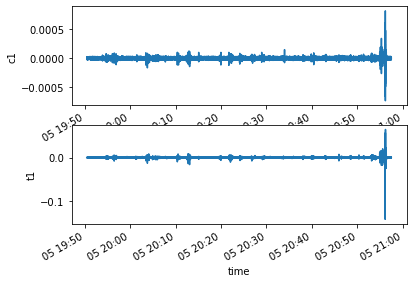

In [23]:
plt.subplot(2,1,1)
(cu1['c1']-cu['c1']).plot()
plt.subplot(2,1,2)
(cu1['t1']-cu['t1']).plot()

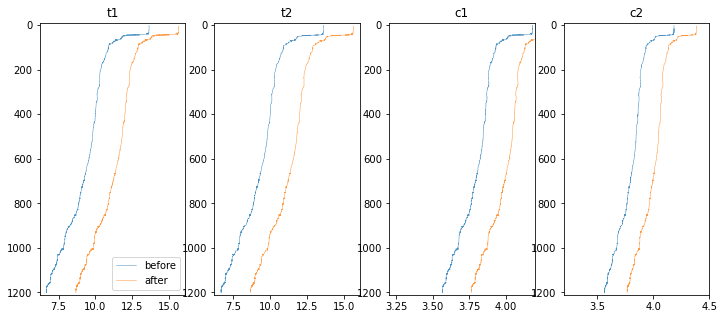

In [25]:
compare(cu, cu1)

In [26]:
cu2 = ctd.calcs.swcalcs(cu1)

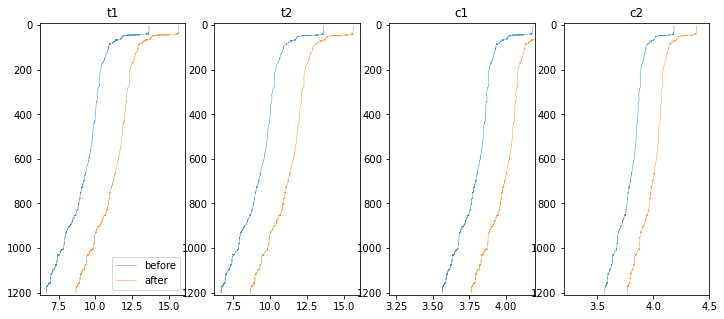

In [96]:
compare(cu1, cu2)

In [31]:
cu3 = ctd.proc.rmloops(cu2)

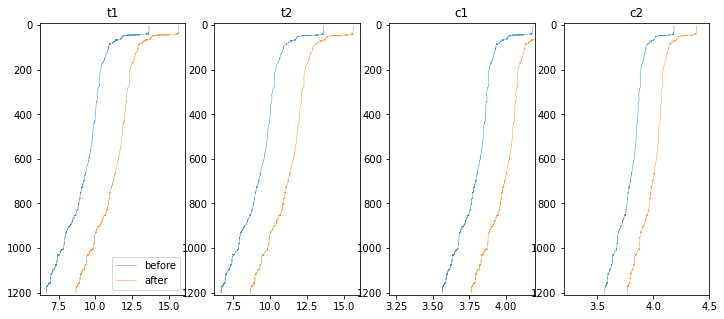

In [97]:
compare(cu2, cu3)

In [94]:
cu4 = ctd.proc.cleanup_ud(cu3)

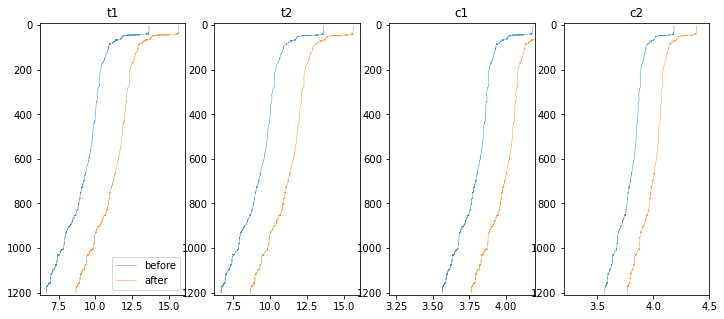

In [98]:
compare(cu3, cu4)

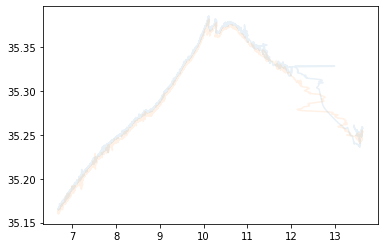

In [107]:
ctd.proc.plot_TS(cu4)